In [16]:
import numpy as np
import scipy
from scipy import fft
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [48]:
k_grid = np.array([   1,    2,    3,    4,    6,    9,   12,   17,   23,   32,
         44,   61,   84,  115,  158,  217,  299,  410,  563,  773, 1061,
       1457, 2000])

In [75]:
theta_res = 1000
theta_range = np.linspace(1e-1, 5, theta_res)
oversample_res = 1000
oversample_pts = np.max(k_grid) * oversample_res
oversampled_k_arr = np.linspace(
    1e-1, 100, oversample_res
)
j0_ktheta_k = (
    scipy.special.j0(np.outer(oversampled_k_arr, theta_range))
    * oversampled_k_arr[:, None]
)

In [80]:
import time

In [87]:
# oversampled_hankel_amps = interp1d(
#         k_grid, scipy.special.jv(1, k_grid) / k_grid, kind="cubic"
#     )(oversampled_k_arr)
start = time.time()
oversampled_hankel_amps = scipy.special.jv(1, oversampled_k_arr) / oversampled_k_arr
inverse_hankel_transf = np.trapz(
    j0_ktheta_k * oversampled_hankel_amps[:, None],
    oversampled_k_arr,
    axis=0,)
end = time.time()
print(end - start)

0.013557195663452148


In [102]:
from pyhank import HankelTransform

transformer = HankelTransform(order=0, max_radius=np.deg2rad(90), n_points=1024)

In [105]:
transformer.kr

ErH = transformer.to_transform_k()

array([1.53095950e+00, 3.51419087e+00, 5.50913429e+00, ...,
       2.04350002e+03, 2.04550002e+03, 2.04750002e+03])

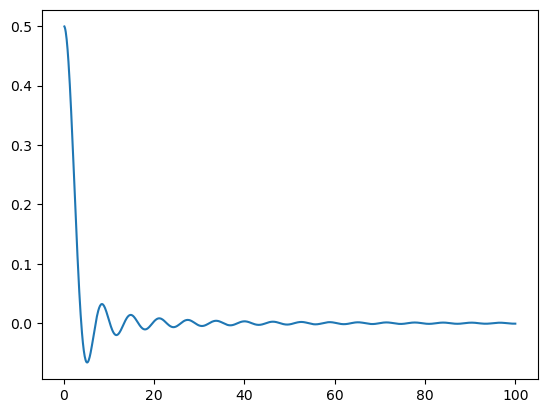

In [77]:
plt.plot(oversampled_k_arr, oversampled_hankel_amps)

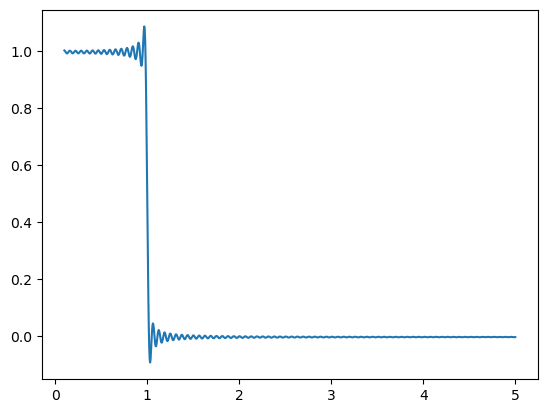

In [78]:
plt.plot(theta_range, inverse_hankel_transf)
# plt.xscale("log")
# plt.yscale("log")

In [11]:
j0_ktheta_k

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.00050025e+00,  9.92887903e-01,  9.70224544e-01, ...,
         6.60267096e-01,  5.68785182e-01,  4.71791672e-01],
       [ 2.00100050e+00,  1.94044909e+00,  1.76428250e+00, ...,
        -4.10545407e-02, -3.65263503e-01, -6.09682814e-01],
       ...,
       [ 1.99799900e+03, -6.03326157e+01,  4.26618149e+01, ...,
        -2.27866871e+01,  2.13113990e+01, -2.00891610e+01],
       [ 1.99899950e+03, -6.99256402e+01,  5.47137780e+01, ...,
        -2.92596029e+01,  2.47430418e+01, -2.01432583e+01],
       [ 2.00000000e+03, -7.73961416e+01,  6.01642820e+01, ...,
         2.81196131e+00, -1.27608013e+01,  2.01308837e+01]])

In [2]:
mu = 0.0                     # Order mu of Bessel function
r = np.logspace(-7, 1, 128)  # Input evaluation points
dln = np.log(r[1]/r[0])      # Step size
offset = fft.fhtoffset(dln, initial=-6*np.log(10), mu=mu)
k = np.exp(offset)/r[::-1]   # Output evaluation points

In [8]:
dln

0.14504473026734127

In [3]:
def f(x, mu):
    """Analytical function: x^(mu+1) exp(-x^2/2)."""
    return x**(mu + 1)*np.exp(-x**2/2)

In [4]:
a_r = f(r, mu)
fht = fft.fht(a_r, dln, mu=mu, offset=offset)

In [5]:
a_k = f(k, mu)
rel_err = abs((fht-a_k)/a_k)

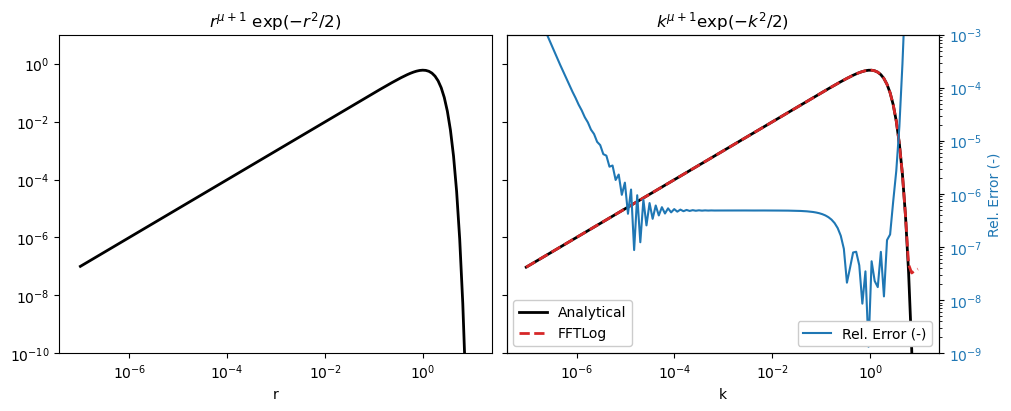

In [6]:
figargs = {'sharex': True, 'sharey': True, 'constrained_layout': True}
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), **figargs)
ax1.set_title(r'$r^{\mu+1}\ \exp(-r^2/2)$')
ax1.loglog(r, a_r, 'k', lw=2)
ax1.set_xlabel('r')
ax2.set_title(r'$k^{\mu+1} \exp(-k^2/2)$')
ax2.loglog(k, a_k, 'k', lw=2, label='Analytical')
ax2.loglog(k, fht, 'C3--', lw=2, label='FFTLog')
ax2.set_xlabel('k')
ax2.legend(loc=3, framealpha=1)
ax2.set_ylim([1e-10, 1e1])
ax2b = ax2.twinx()
ax2b.loglog(k, rel_err, 'C0', label='Rel. Error (-)')
ax2b.set_ylabel('Rel. Error (-)', color='C0')
ax2b.tick_params(axis='y', labelcolor='C0')
ax2b.legend(loc=4, framealpha=1)
ax2b.set_ylim([1e-9, 1e-3])
plt.show()